# FinMan Health Insurance Customer Identification

## Business Problem

FinMan is a health insurance company which provides policies, loans and investment oppurtunities. The business problem that needs to be solved is to identify the customers who will be interested in the new policies of the company based on the information collected from the existing and new customers who visit the website.

## Importing Libraries

In [12]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import os
import sqlite3
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV
    

import re
import string
import pickle

from tqdm import tqdm
from collections import Counter

## Dataset Description

The `train.csv` data set provided by FinMan contains the following features:

Feature | Description 
----------|---------------
**`ID`** | A unique identifier for the customer.   
**`City_Code`**    | Code for the City of the customers <br> **Examples:** 'C10'
**`Region_Code`** | Code for the Region of the customers <br> **Examples:** '3213'
**`Accomodation_Type`** | Customer Owns or Rents the house <br> **Examples:** 'Rented' or 'Owned'
**`Reco_Insurance_Type`** | Joint or Individual type for the recommended insurance 
**`Upper_Age`** | Customer Owns or Rents the house <br> **Examples:** 'Rented' or 'Owned'
**`Lower _Age`** | Customer Owns or Rents the house <br> **Examples:** 'Rented' or 'Owned'<br><ul><li><code>Same as Upper_age incase of Individual Insurance type</code></li>
**`Is_Spouse`** | If the customers are married to each other
(in case of joint insurance) (0/1)
**`Health_Indicator`** | Encoded values for health of the customer <br> **Examples:** 'X1'
**`Holding_Policy_Duration`** | Duration (in years) of holding policy (a policy that customer has already subscribed to with the company) **Examples:** '14+'
**`Holding_Policy_Type`** | Type of holding policy <br> **Examples:** 'Rented' or 'Owned'
**`Type of holding policy`** | Customer Owns or Rents the house <br> **Examples:** '3'
**`Reco_Policy_Cat`** | Customer Owns or Rents the house <br> **Examples:** 'Rented' or 'Owned'
**`Reco_Policy_Premium`** | Annual Premium (INR) for the recommended health insurance <br> <br>
**`Response`** | Classification variable which denotes whether the customer is interested(1) or not interested(0) in the policy 



## 1. Reading the Data

In [3]:
policy_df = pd.read_csv('.data/train_Df64byy.csv')
print(policy_df.shape)
policy_df.head()

(50882, 14)


,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response
0,1,C3,3213,Rented,Individual,36,36,No,X1,14+,3.0,22,11628.0,0
1,2,C5,1117,Owned,Joint,75,22,No,X2,NaN,NaN,22,30510.0,0
2,3,C5,3732,Owned,Individual,32,32,No,NaN,1.0,1.0,19,7450.0,1
3,4,C24,4378,Owned,Joint,52,48,No,X1,14+,3.0,19,17780.0,0
4,5,C8,2190,Rented,Individual,44,44,No,X2,3.0,1.0,16,10404.0,0


<h2>2. Exploratory Data Analysis</h2>

Number of customers showed interest  12209 , ( 23.99473291144216 %)
Number of customers that did not show interest  38673 , ( 76.00526708855784 %)


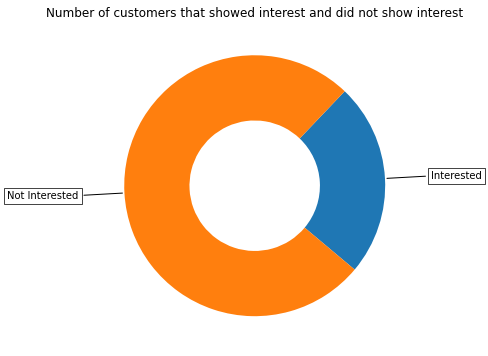

In [4]:
y_value_counts = policy_df['Response'].value_counts()
print("Number of customers showed interest ", y_value_counts[1], ", (", (y_value_counts[1]/(y_value_counts[1]+y_value_counts[0]))*100,"%)")
print("Number of customers that did not show interest ", y_value_counts[0], ", (", (y_value_counts[0]/(y_value_counts[1]+y_value_counts[0]))*100,"%)")

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(aspect="equal"))
recipe = ["Interested", "Not Interested"]

data = [y_value_counts[1], y_value_counts[0]]

wedges, texts = ax.pie(data, wedgeprops=dict(width=0.5), startangle=-40)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(xycoords='data', textcoords='data', arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(recipe[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                 horizontalalignment=horizontalalignment, **kw)

ax.set_title("Number of customers that showed interest and did not show interest")

plt.show()

This shows that majority of the customers in the dataset did not show interest in buying FinMan's Health Insurance policy and there is a class imbalance of the ratio 1:3 approximately  

## 2.1 Missing Values

In [5]:
policy_df.isnull().sum()

ID                             0
City_Code                      0
Region_Code                    0
Accomodation_Type              0
Reco_Insurance_Type            0
Upper_Age                      0
Lower_Age                      0
Is_Spouse                      0
Health Indicator           11691
Holding_Policy_Duration    20251
Holding_Policy_Type        20251
Reco_Policy_Cat                0
Reco_Policy_Premium            0
Response                       0
dtype: int64

The missing values in the Holding Policy Duration and Holding Policy type indicates the customer has not taken any previous Insurance policies/loan/investment from the company. The missing values in the health indicator might be because the customers have not disclosed the information.

## 2.2.1 Univariate Analysis: Categorical variables

In [6]:
#stacked bar plots matplotlib: https://matplotlib.org/gallery/lines_bars_and_markers/bar_stacked.html
def stack_plot(data, xtick, col2='Response', col3='total'):
    ind = np.arange(data.shape[0])
    
    plt.figure(figsize=(20,5))
    p1 = plt.bar(ind, data[col3].values)
    p2 = plt.bar(ind, data[col2].values)

    plt.ylabel('Customers')
    plt.title('% of customers interested ' + xtick + ' wise')
    plt.xticks(ind, list(data[xtick].values))
    plt.legend((p1[0], p2[0]), ('total', 'interested'))
    plt.show()

In [7]:
def univariate_barplots(data, col1, col2='Response', top=False):
    # Count number of zeros in dataframe python: https://stackoverflow.com/a/51540521/4084039
    temp = pd.DataFrame(data.groupby(col1)[col2].agg(lambda x: x.eq(1).sum())).reset_index()

    # Pandas dataframe grouby count: https://stackoverflow.com/a/19385591/4084039
    temp['total'] = pd.DataFrame(data.groupby(col1)[col2].agg(total='count')).reset_index()['total']
    temp['Avg'] = pd.DataFrame(data.groupby(col1)[col2].agg(Avg='mean')).reset_index()['Avg']
    temp.sort_values(by=['total'],inplace=True, ascending=False)
    
    if top:
        temp = temp[0:top]
    
    stack_plot(temp, xtick=col1, col2=col2, col3='total')
    print(temp.head(5))
    print("="*50)
    print(temp.tail(5))


 City_Code

Categories: ['C3' 'C5' 'C24' 'C8' 'C9' 'C1' 'C15' 'C28' 'C27' 'C7' 'C20' 'C25' 'C4'
 'C2' 'C34' 'C10' 'C17' 'C18' 'C16' 'C29' 'C33' 'C26' 'C19' 'C6' 'C12'
 'C13' 'C11' 'C14' 'C22' 'C23' 'C21' 'C36' 'C32' 'C30' 'C35' 'C31'] 
No of Categories 36


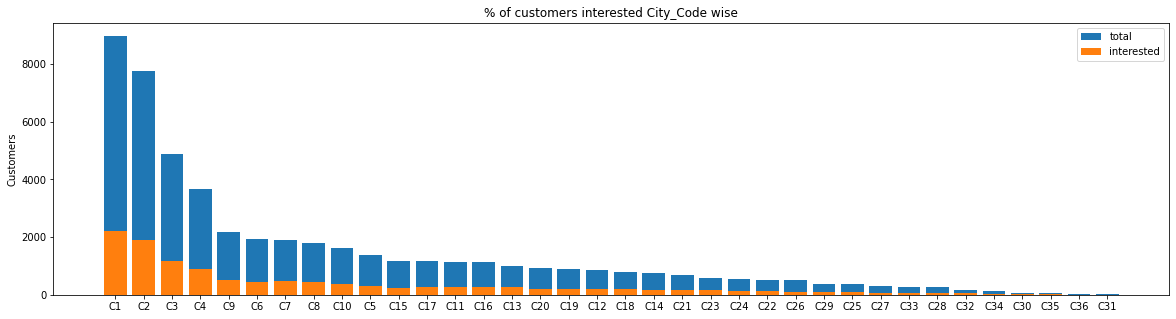

   City_Code  Response  total       Avg
0         C1      2208   8973  0.246072
11        C2      1893   7747  0.244353
22        C3      1161   4889  0.237472
30        C4       889   3671  0.242168
35        C9       510   2185  0.233410
   City_Code  Response  total       Avg
27       C34        36    130  0.276923
23       C30        18     58  0.310345
28       C35        16     56  0.285714
29       C36         5     36  0.138889
24       C31         2     15  0.133333

----------------------------------------------------------------------------------------------------


 Accomodation_Type

Categories: ['Rented' 'Owned'] 
No of Categories 2


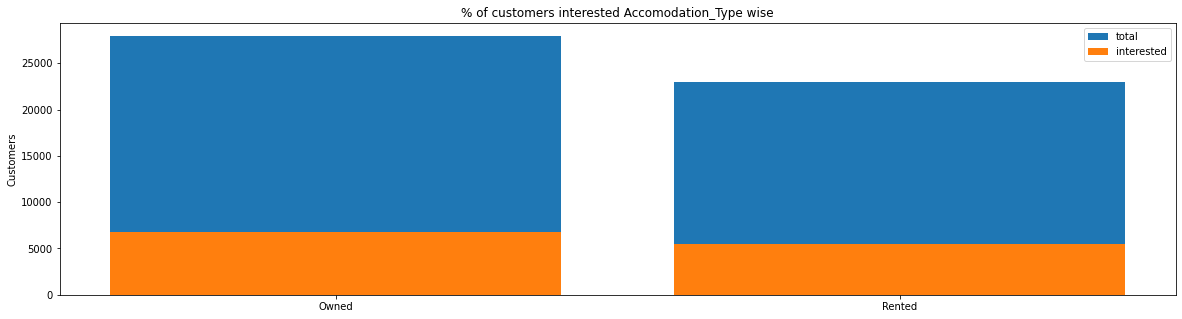

  Accomodation_Type  Response  total       Avg
0             Owned      6763  27951  0.241959
1            Rented      5446  22931  0.237495
  Accomodation_Type  Response  total       Avg
0             Owned      6763  27951  0.241959
1            Rented      5446  22931  0.237495

----------------------------------------------------------------------------------------------------


 Reco_Insurance_Type

Categories: ['Individual' 'Joint'] 
No of Categories 2


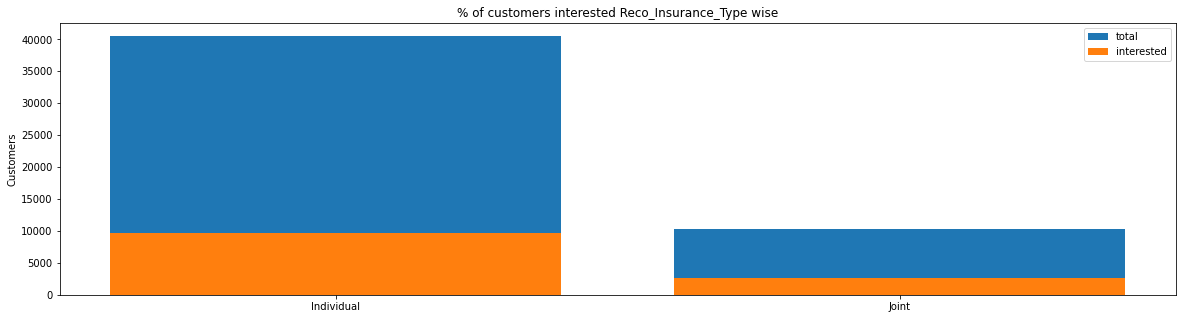

  Reco_Insurance_Type  Response  total       Avg
0          Individual      9640  40536  0.237813
1               Joint      2569  10346  0.248309
  Reco_Insurance_Type  Response  total       Avg
0          Individual      9640  40536  0.237813
1               Joint      2569  10346  0.248309

----------------------------------------------------------------------------------------------------


 Is_Spouse

Categories: ['No' 'Yes'] 
No of Categories 2


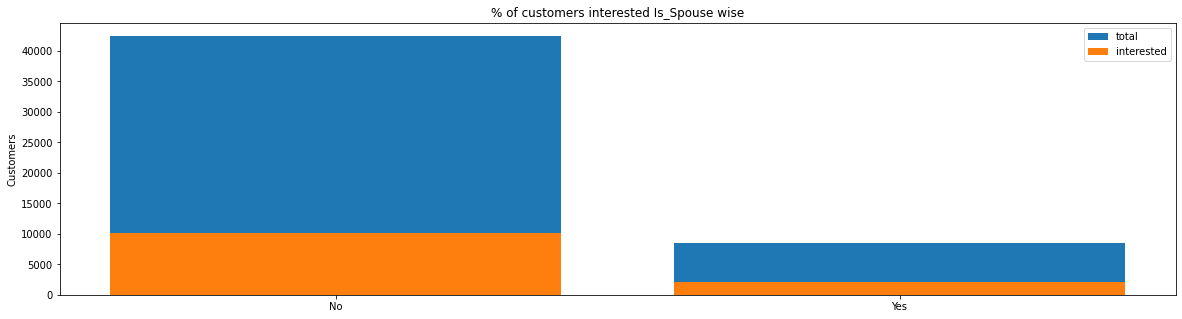

  Is_Spouse  Response  total       Avg
0        No     10157  42460  0.239213
1       Yes      2052   8422  0.243648
  Is_Spouse  Response  total       Avg
0        No     10157  42460  0.239213
1       Yes      2052   8422  0.243648

----------------------------------------------------------------------------------------------------


 Health Indicator

Categories: ['X1' 'X2' nan 'X4' 'X3' 'X6' 'X5' 'X8' 'X7' 'X9'] 
No of Categories 10


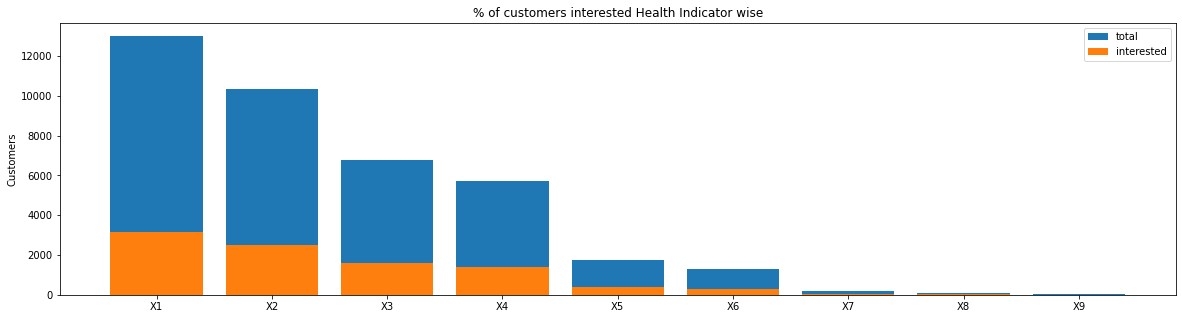

  Health Indicator  Response  total       Avg
0               X1      3176  13010  0.244120
1               X2      2491  10332  0.241096
2               X3      1599   6762  0.236469
3               X4      1396   5743  0.243079
4               X5       408   1727  0.236248
  Health Indicator  Response  total       Avg
4               X5       408   1727  0.236248
5               X6       307   1280  0.239844
6               X7        62    196  0.316327
7               X8        18     78  0.230769
8               X9        14     63  0.222222

----------------------------------------------------------------------------------------------------


 Holding_Policy_Type

Categories: [ 3. nan  1.  4.  2.] 
No of Categories 5


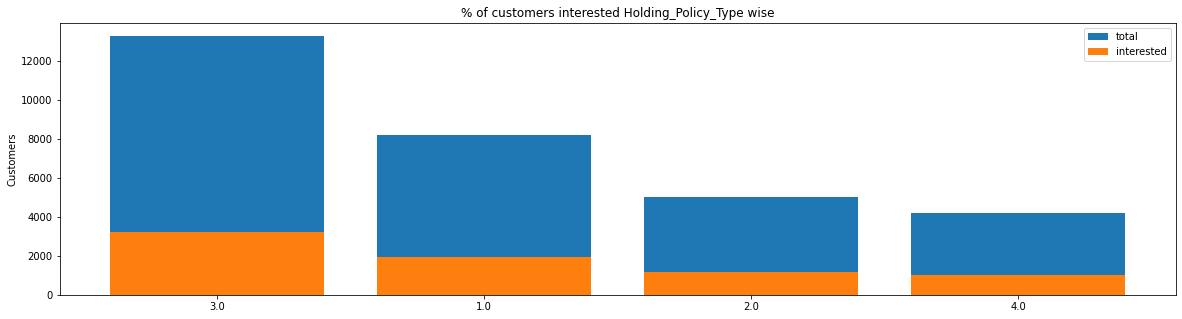

   Holding_Policy_Type  Response  total       Avg
2                  3.0      3217  13279  0.242262
0                  1.0      1927   8173  0.235776
1                  2.0      1190   5005  0.237762
3                  4.0      1036   4174  0.248203
   Holding_Policy_Type  Response  total       Avg
2                  3.0      3217  13279  0.242262
0                  1.0      1927   8173  0.235776
1                  2.0      1190   5005  0.237762
3                  4.0      1036   4174  0.248203

----------------------------------------------------------------------------------------------------


 Reco_Policy_Cat

Categories: [22 19 16 17  1 18 21 13 20  9  2  4 12  6 14 11  3  8  7 10 15  5] 
No of Categories 22


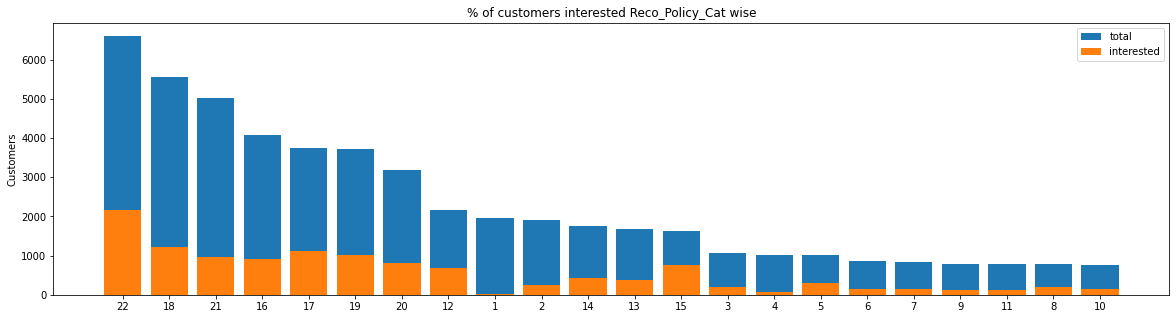

    Reco_Policy_Cat  Response  total       Avg
21               22      2168   6602  0.328385
17               18      1225   5553  0.220601
20               21       974   5027  0.193754
15               16       913   4084  0.223555
16               17      1121   3756  0.298456
    Reco_Policy_Cat  Response  total       Avg
6                 7       155    834  0.185851
8                 9       131    789  0.166033
10               11       130    781  0.166453
7                 8       209    776  0.269330
9                10       136    770  0.176623

----------------------------------------------------------------------------------------------------



In [8]:
for i in range(1,len(policy_df.columns)):
    if policy_df.columns[i] in ('City_Code','Accomodation_Type','Reco_Insurance_Type','Is_Spouse','Reco_Policy_Cat','Health Indicator','Holding_Policy_Type'):
        print('\n',policy_df.columns[i])
        print('\nCategories:',policy_df[policy_df.columns[i]].unique(),'\nNo of Categories',len(policy_df[policy_df.columns[i]].unique()))
        univariate_barplots(policy_df, policy_df.columns[i], 'Response', False)
        print('\n----------------------------------------------------------------------------------------------------\n')

In [9]:
print('Region_Code\n',policy_df['Region_Code'].unique(),'\nNumber of Categories:',len(policy_df['Region_Code'].unique()))

Region_Code
 [3213 1117 3732 ... 5326 6149 5450] 
Number of Categories: 5316


## 2.2.2 Univariate Analysis: Numerical features

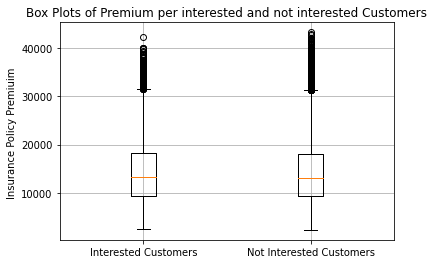

In [10]:
interested_premium = policy_df[policy_df['Response']==1]['Reco_Policy_Premium'].values

not_interested_premium = policy_df[policy_df['Response']==0]['Reco_Policy_Premium'].values

plt.boxplot([interested_premium, not_interested_premium])
plt.title('Box Plots of Premium per interested and not interested Customers')
plt.xticks([1,2],('Interested Customers','Not Interested Customers'))
plt.ylabel('Insurance Policy Premiuim ')
plt.grid()
plt.show()

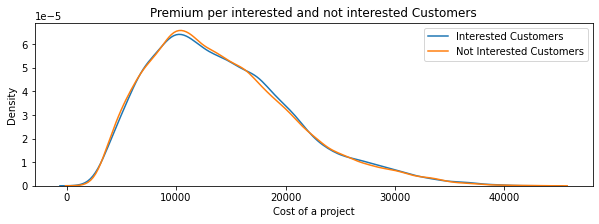

In [11]:
plt.figure(figsize=(10,3))
sns.distplot(interested_premium, hist=False, label='Interested Customers')
sns.distplot(not_interested_premium, hist=False, label='Not Interested Customers')
plt.title('Premium per interested and not interested Customers')
plt.xlabel('Cost of a project')
plt.legend()
plt.show()

### Points to Ponder
1. There are certain columns like 'City_Code' and 'Health Indicator' where it has very less data points from categories like 'C31','C36'(City_Code) and 8,10(Health Indicator')
2. For almost all the columns, Every category in a column has an similar ratio of negative:positive examples denoted by the average column in the table.
3. The distributions and box plots of insurance policy premium for both the interested and not interested customers are similar
4. Since the dataset is imbalanced, SMOTE technique can be used to synthetically generate data or class weights can be used to balance the weights of the model.

## 3. Data Validation

### 3.1.Check if all customers with individual account has the same upper age and lower age

In [15]:
policy_df = pd.read_csv('.data/train_Df64byy.csv')

print('Number of rows of Individual account:',policy_df[(policy_df['Reco_Insurance_Type']== 'Individual')].shape[0])
print('Number of rows of Individual account with same upper_age and lower_age:',policy_df[(policy_df['Reco_Insurance_Type']== 'Individual') & (policy_df['Upper_Age']== policy_df['Lower_Age'])].shape[0])

print('Number of rows of Joint account:',policy_df[(policy_df['Reco_Insurance_Type']== 'Joint')].shape[0])
print('Number of rows of Joint account with different upper_age and lower_age:',policy_df[(policy_df['Reco_Insurance_Type']== 'Joint') & (policy_df['Upper_Age'] != policy_df['Lower_Age'])].shape[0])
print('\nTherefore all the customers with with individual account has the same upper age and lower age and customers with joint account has different upper_age and lower age')

Number of rows of Individual account: 40536
Number of rows of Individual account with same upper_age and lower_age: 40536
Number of rows of Joint account: 10346
Number of rows of Joint account with different upper_age and lower_age: 10346

Therefore all the customers with with individual account has the same upper age and lower age and customers with joint account has different upper_age and lower age


### 3.2. Check if for all Individual accounts, there are no spouses

In [16]:
print('This means that spouse information is not provided for individual accounts')
policy_df[(policy_df['Reco_Insurance_Type'] == 'Individual')&(policy_df['Is_Spouse']== 'Yes')]

This means that spouse information is not provided for individual accounts


,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response


### 3.3 Check if all the missing values in Holding_policy_Duration and Holding_Policy_type are in the same rows

In [17]:
if policy_df[(policy_df['Holding_Policy_Duration'].isna())].shape[0] == policy_df[(policy_df['Holding_Policy_Duration'].isna())&(policy_df['Holding_Policy_Type'].isna())].shape[0]:
    print('There are no previous policies taken by the customers for the missing rows of Holding_policy_Duration and Holding_Policy_type')

There are no previous policies taken by the customers for the missing rows of Holding_policy_Duration and Holding_Policy_type


A new binary feature can be created based on whether the company has any previous policy/loan or Investments with the company

## 4. Handling Missing Values - Model Based Imputation

In [120]:
policy_df = pd.read_csv('.data/train_Df64byy.csv')
policy_df_train = policy_df[policy_df['Health Indicator'].isna()== False]

y = policy_df_train['Health Indicator'].values
X = policy_df_train.drop(['Health Indicator'], axis=1)
X = policy_df_train.drop(['ID'], axis=1)

X['Holding_Policy_Duration'] = X['Holding_Policy_Duration'].replace(np.nan, '0', regex=True)
X['Holding_Policy_Type'] = X['Holding_Policy_Type'].replace(np.nan, 'No_policy', regex=True)

X['Holding_Policy_Type'] = X['Holding_Policy_Type'].astype(str)
X['Region_Code'] = X['Region_Code'].astype(str)
X['Reco_Policy_Cat'] = X['Reco_Policy_Cat'].astype(str)

In [121]:
X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.2, stratify=y,random_state=45)
X_train.shape

(31352, 13)

In [122]:
policy_df_test = policy_df[policy_df['Health Indicator'].isna()]
#X_test = policy_df_test.drop(['ID'], axis=1)
X_test['Holding_Policy_Duration'] = X_test['Holding_Policy_Duration'].replace(np.nan, 'nan', regex=True)
X_test['Holding_Policy_Type'] = X_test['Holding_Policy_Type'].replace(np.nan, 'nan', regex=True)
X_test['Region_Code'] = X_test['Region_Code'].astype(str)
X_test['Holding_Policy_Type'] = X_test['Holding_Policy_Type'].astype(str)
X_test['Reco_Policy_Cat'] = X_test['Reco_Policy_Cat'].astype(str)
print(X_test.shape)
X_test.head()

(11691, 13)


,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response
2,C5,3732,Owned,Individual,32,32,No,NaN,1.0,1.0,19,7450.0,1
6,C3,679,Owned,Individual,28,28,No,NaN,nan,nan,17,10640.0,0
9,C1,530,Owned,Joint,59,26,Yes,NaN,7.0,4.0,18,21100.8,1
12,C7,3453,Owned,Individual,66,66,No,NaN,1.0,2.0,20,17192.0,1
19,C20,973,Owned,Individual,27,27,No,NaN,nan,nan,4,8050.0,0


In [67]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['City_Code'].values) # fit has to happen only on train data

feature_names=[]

# we use the fitted CountVectorizer to convert the text to vector
X_train_city_ohe = vectorizer.transform(X_train['City_Code'].values)
X_cv_city_ohe = vectorizer.transform(X_cv['City_Code'].values)
X_test_city_ohe = vectorizer.transform(X_test['City_Code'].values)

print("After vectorizations")
print(X_train_city_ohe.shape, y_train.shape)
print(X_cv_city_ohe.shape, y_cv.shape)
print(X_test_city_ohe.shape)
print(vectorizer.get_feature_names(),len(vectorizer.get_feature_names()))
feature_names.extend(vectorizer.get_feature_names())
print("="*100)

After vectorizations
(31352, 36) (31352,)
(7839, 36) (7839,)
(11691, 36)
['c1', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19', 'c2', 'c20', 'c21', 'c22', 'c23', 'c24', 'c25', 'c26', 'c27', 'c28', 'c29', 'c3', 'c30', 'c31', 'c32', 'c33', 'c34', 'c35', 'c36', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'] 36


In [68]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['Region_Code'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_region_ohe = vectorizer.transform(X_train['Region_Code'].values)
X_cv_region_ohe = vectorizer.transform(X_cv['Region_Code'].values)
X_test_region_ohe = vectorizer.transform(X_test['Region_Code'].values)

print("After vectorizations")
print(X_train_region_ohe.shape, y_train.shape)
print(X_cv_region_ohe.shape, y_cv.shape)
print(X_test_region_ohe.shape)
print(len(vectorizer.get_feature_names()))
feature_names.extend(vectorizer.get_feature_names())
print("="*100)

After vectorizations
(31352, 4972) (31352,)
(7839, 4972) (7839,)
(11691, 4972)
4972


In [69]:
# creating instance of labelencoder
labelencoder = LabelEncoder()
# Assigning numerical values and storing in another column
labelencoder.fit(X_train['Accomodation_Type'])

# we use the fitted CountVectorizer to convert the text to vector
X_train_accomodation_ohe = labelencoder.transform(X_train['Accomodation_Type'].values).reshape(-1,1)
X_cv_accomodation_ohe = labelencoder.transform(X_cv['Accomodation_Type'].values).reshape(-1,1)
X_test_accomodation_ohe = labelencoder.transform(X_test['Accomodation_Type'].values).reshape(-1,1)

print("After vectorizations")
print(X_train_accomodation_ohe.shape, y_train.shape)
print(X_cv_accomodation_ohe.shape, y_cv.shape)
#print(labelencoder.get_feature_names())
feature_names.extend('Accomodation_Type')
print("="*100)

After vectorizations
(31352, 1) (31352,)
(7839, 1) (7839,)


In [70]:
# creating instance of labelencoder
labelencoder = LabelEncoder()
# Assigning numerical values and storing in another column
labelencoder.fit(X_train['Reco_Insurance_Type'])

# we use the fitted CountVectorizer to convert the text to vector
X_train_ins_type_ohe = labelencoder.transform(X_train['Reco_Insurance_Type'].values).reshape(-1,1)
X_cv_ins_type_ohe = labelencoder.transform(X_cv['Reco_Insurance_Type'].values).reshape(-1,1)
X_test_ins_type_ohe = labelencoder.transform(X_test['Reco_Insurance_Type'].values).reshape(-1,1)

print("After vectorizations")
print(X_train_ins_type_ohe.shape, y_train.shape)
print(X_cv_ins_type_ohe.shape, y_cv.shape)
#print(labelencoder.get_feature_names())
feature_names.extend('Reco_Insurance_Type')
print("="*100)

After vectorizations
(31352, 1) (31352,)
(7839, 1) (7839,)


In [71]:
# creating instance of labelencoder
labelencoder = LabelEncoder()
# Assigning numerical values and storing in another column
labelencoder.fit(X_train['Is_Spouse'])

# we use the fitted CountVectorizer to convert the text to vector
X_train_spouse_ohe = labelencoder.transform(X_train['Is_Spouse'].values).reshape(-1,1)
X_cv_spouse_ohe = labelencoder.transform(X_cv['Is_Spouse'].values).reshape(-1,1)
X_test_spouse_ohe = labelencoder.transform(X_test['Is_Spouse'].values).reshape(-1,1)

print("After vectorizations")
print(X_train_spouse_ohe.shape, y_train.shape)
print(X_cv_spouse_ohe.shape, y_cv.shape)
#print(labelencoder.get_feature_names())
feature_names.extend('Is_Spouse')
print("="*100)

After vectorizations
(31352, 1) (31352,)
(7839, 1) (7839,)


In [72]:
# creating instance of labelencoder
labelencoder = LabelEncoder()
# Assigning numerical values and storing in another column
labelencoder.fit(X_train['Response'])

# we use the fitted CountVectorizer to convert the text to vector
X_train_response_ohe = labelencoder.transform(X_train['Response'].values).reshape(-1,1)
X_cv_response_ohe = labelencoder.transform(X_cv['Response'].values).reshape(-1,1)
X_test_response_ohe = labelencoder.transform(X_test['Response'].values).reshape(-1,1)

print("After vectorizations")
print(X_train_response_ohe.shape, y_train.shape)
print(X_cv_response_ohe.shape, y_cv.shape)
#print(labelencoder.get_feature_names())
feature_names.extend('Response')
print("="*100)

After vectorizations
(31352, 1) (31352,)
(7839, 1) (7839,)


In [73]:
#token_pattern is set as the default token pattern in CountVectorizer does not capture 'single characters'
vectorizer = CountVectorizer(token_pattern='\\b\\w+\\b')

vectorizer.fit(X_train['Holding_Policy_Duration'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_hold_dur_ohe = vectorizer.transform(X_train['Holding_Policy_Duration'].values)
X_cv_hold_dur_ohe = vectorizer.transform(X_cv['Holding_Policy_Duration'].values)
X_test_hold_dur_ohe = vectorizer.transform(X_test['Holding_Policy_Duration'].values)

print("After vectorizations")
print(X_train_hold_dur_ohe.shape, y_train.shape)
print(X_cv_hold_dur_ohe.shape, y_cv.shape)
print(vectorizer.get_feature_names(),len(vectorizer.get_feature_names()))
feature_names.extend(vectorizer.get_feature_names())
print("="*100)

After vectorizations
(31352, 15) (31352,)
(7839, 15) (7839,)
['0', '1', '10', '11', '12', '13', '14', '2', '3', '4', '5', '6', '7', '8', '9'] 15


In [74]:
vectorizer = CountVectorizer(token_pattern='\\b\\w+\\b')

vectorizer.fit(X_train['Holding_Policy_Type'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_hold_type_ohe = vectorizer.transform(X_train['Holding_Policy_Type'].values)
X_cv_hold_type_ohe = vectorizer.transform(X_cv['Holding_Policy_Type'].values)
X_test_hold_type_ohe = vectorizer.transform(X_test['Holding_Policy_Type'].values)

print("After vectorizations")
print(X_train_hold_type_ohe.shape, y_train.shape)
print(X_cv_hold_type_ohe.shape, y_cv.shape)
print(vectorizer.get_feature_names(),len(vectorizer.get_feature_names()))
feature_names.extend(vectorizer.get_feature_names())
print("="*100)

After vectorizations
(31352, 6) (31352,)
(7839, 6) (7839,)
['0', '1', '2', '3', '4', 'no_policy'] 6


In [75]:
vectorizer = CountVectorizer(token_pattern='\\b\\w+\\b')

vectorizer.fit(X_train['Reco_Policy_Cat'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_pol_cat_ohe = vectorizer.transform(X_train['Reco_Policy_Cat'].values)
X_cv_pol_cat_ohe = vectorizer.transform(X_cv['Reco_Policy_Cat'].values)
X_test_pol_cat_ohe = vectorizer.transform(X_test['Reco_Policy_Cat'].values)

print("After vectorizations")
print(X_train_pol_cat_ohe.shape, y_train.shape)
print(X_cv_pol_cat_ohe.shape, y_cv.shape)
print(vectorizer.get_feature_names(),len(vectorizer.get_feature_names()))
feature_names.extend(vectorizer.get_feature_names())
print("="*100)

After vectorizations
(31352, 22) (31352,)
(7839, 22) (7839,)
['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '3', '4', '5', '6', '7', '8', '9'] 22


In [76]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()

normalizer.fit(X_train['Upper_Age'].values.reshape(-1,1))

X_train_upper_age_norm = normalizer.transform(X_train['Upper_Age'].values.reshape(-1,1))
X_cv_upper_age_norm = normalizer.transform(X_cv['Upper_Age'].values.reshape(-1,1))
X_test_upper_age_norm = normalizer.transform(X_test['Upper_Age'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_upper_age_norm.shape, y_train.shape)
print(X_cv_upper_age_norm.shape, y_cv.shape)
feature_names.extend('Upper_Age')
print("="*100)


After vectorizations
(31352, 1) (31352,)
(7839, 1) (7839,)


In [77]:
normalizer = Normalizer()

normalizer.fit(X_train['Lower_Age'].values.reshape(-1,1))

X_train_lower_age_norm = normalizer.transform(X_train['Lower_Age'].values.reshape(-1,1))
X_cv_lower_age_norm = normalizer.transform(X_cv['Lower_Age'].values.reshape(-1,1))
X_test_lower_age_norm = normalizer.transform(X_test['Lower_Age'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_lower_age_norm.shape, y_train.shape)
print(X_cv_lower_age_norm.shape, y_cv.shape)
feature_names.extend('Lower_Age')
print("="*100)


After vectorizations
(31352, 1) (31352,)
(7839, 1) (7839,)


In [78]:
normalizer = Normalizer()

normalizer.fit(X_train['Reco_Policy_Premium'].values.reshape(-1,1))

X_train_pol_prem_norm = normalizer.transform(X_train['Reco_Policy_Premium'].values.reshape(-1,1))
X_cv_pol_prem_norm = normalizer.transform(X_cv['Reco_Policy_Premium'].values.reshape(-1,1))
X_test_pol_prem_norm = normalizer.transform(X_test['Reco_Policy_Premium'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_pol_prem_norm.shape, y_train.shape)
print(X_cv_pol_prem_norm.shape, y_cv.shape)
feature_names.extend('Reco_Policy_Premium')
print("="*100)


After vectorizations
(31352, 1) (31352,)
(7839, 1) (7839,)


In [80]:
## Concatenating all features

from scipy.sparse import hstack
X_tr = hstack((X_train_city_ohe,X_train_region_ohe,X_train_accomodation_ohe,X_train_ins_type_ohe,X_train_spouse_ohe,X_train_response_ohe,X_train_hold_dur_ohe,X_train_hold_type_ohe,X_train_pol_cat_ohe,X_train_upper_age_norm,X_train_lower_age_norm,X_train_pol_prem_norm)).tocsr()
X_cr = hstack((X_cv_city_ohe,X_cv_region_ohe,X_cv_accomodation_ohe,X_cv_ins_type_ohe,X_cv_spouse_ohe,X_cv_response_ohe,X_cv_hold_dur_ohe,X_cv_hold_type_ohe,X_cv_pol_cat_ohe,X_cv_upper_age_norm,X_cv_lower_age_norm,X_cv_pol_prem_norm)).tocsr()
X_te = hstack((X_test_city_ohe,X_test_region_ohe,X_test_accomodation_ohe,X_test_ins_type_ohe,X_test_spouse_ohe,X_test_response_ohe,X_test_hold_dur_ohe,X_test_hold_type_ohe,X_test_pol_cat_ohe,X_test_upper_age_norm,X_test_lower_age_norm,X_test_pol_prem_norm)).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_cr.shape, y_cv.shape)
print(X_te.shape)
print("="*100)

Final Data matrix
(31352, 5058) (31352,)
(7839, 5058) (7839,)
(11691, 5058)


<h2>4.1 Appling NB on different kind of featurization</h2>

In [81]:
def batch_predict(clf, data):
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs

    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
    # we will be predicting for the last data points
    if data.shape[0]%1000 !=0:
        y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    return y_data_pred

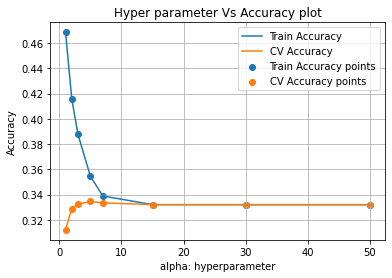

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.037014,0.001409,0.004997,0.000004,1,{'alpha': 1},0.308966,0.318534,0.308421,0.311974,0.004644,8,0.470839,0.468303,0.466702,0.468614,0.001703
1,0.036007,0.000010,0.005003,0.000007,2,{'alpha': 2},0.327241,0.333939,0.325550,0.328910,0.003622,7,0.415674,0.417301,0.415032,0.416002,0.000955
2,0.035678,0.000475,0.005331,0.000470,3,{'alpha': 3},0.333174,0.335470,0.328230,0.332291,0.003021,3,0.388402,0.387589,0.387044,0.387679,0.000558
3,0.035680,0.000473,0.005328,0.000469,5,{'alpha': 5},0.332695,0.335757,0.335120,0.334524,0.001319,1,0.354768,0.353237,0.355516,0.354507,0.000949
4,0.036682,0.000948,0.005328,0.000473,7,{'alpha': 7},0.332504,0.332887,0.335024,0.333472,0.001109,2,0.339075,0.337400,0.340159,0.338878,0.001135


In [102]:
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV


summary=[]

clf_nb = MultinomialNB()
parameters = {'alpha':[1, 2, 3, 5, 7, 15,30,50]}
clf = GridSearchCV(clf_nb, parameters, cv=3, scoring='accuracy',return_train_score=True)
clf.fit(X_tr, y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_alpha'])

train_auc= results['mean_train_score']
train_auc_std= results['std_train_score']
cv_auc = results['mean_test_score'] 
cv_auc_std= results['std_test_score']
K =  results['param_alpha']

plt.plot(K, train_auc, label='Train Accuracy')

plt.plot(K, cv_auc, label='CV Accuracy')

plt.scatter(K, train_auc, label='Train Accuracy points')
plt.scatter(K, cv_auc, label='CV Accuracy points')


plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("Accuracy")
plt.title("Hyper parameter Vs Accuracy plot")
plt.grid()
plt.show()

results.head()

#### Testing the performance of the model on test data, plotting ROC Curves

In [103]:
clf.best_params_

{'alpha': 5}

In [104]:
#here we are choosing the best_alpha based on forloop results
best_alpha = 5

In [105]:
clf = MultinomialNB(alpha = best_alpha)
clf.fit(X_tr, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = batch_predict(clf, X_tr)    
y_test_pred = batch_predict(clf, X_cr)

train_acc=accuracy_score(y_train, y_train_pred_result)
cv_acc=accuracy_score(y_cv, y_cv_pred_result)
print('Train Accuracy:',train_acc)
print('Test Accuracy:',cv_acc)
summary.append(['Naive Bayes',best_alpha,np.round(cv_acc,2)])

Train Accuracy: 0.3352577188058178
Test Accuracy: 0.33499170812603646


## 4.2 Apply KNN

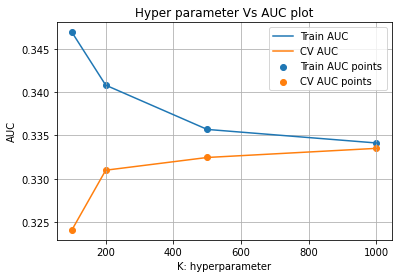

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.014343,0.001249,7.137312,0.147515,100,{'n_neighbors': 100},0.323797,0.329155,0.319330,0.324094,0.004017,4,0.346347,0.344720,0.349632,0.346900,0.002043
1,0.014002,0.000813,7.791503,0.775733,200,{'n_neighbors': 200},0.329059,0.334800,0.329091,0.330984,0.002699,3,0.340749,0.340079,0.341546,0.340792,0.000600
2,0.013670,0.000473,7.798392,0.266269,500,{'n_neighbors': 500},0.331164,0.332695,0.333493,0.332451,0.000966,2,0.336348,0.335199,0.335518,0.335688,0.000484
3,0.013668,0.000944,8.150968,0.275715,1000,{'n_neighbors': 1000},0.332313,0.333078,0.335120,0.333503,0.001185,1,0.333525,0.334960,0.333891,0.334125,0.000609


In [98]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score

neigh = KNeighborsClassifier(n_jobs=-1)
parameters = {'n_neighbors':[100,200,500,1000]}
clf = RandomizedSearchCV(neigh, parameters, cv=3, scoring='accuracy',return_train_score=True)
clf.fit(X_tr, y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_n_neighbors'])

train_auc= results['mean_train_score']
train_auc_std= results['std_train_score']
cv_auc = results['mean_test_score'] 
cv_auc_std= results['std_test_score']
K =  results['param_n_neighbors']

plt.plot(K, train_auc, label='Train Accuracy')

plt.plot(K, cv_auc, label='CV Accuracy')

plt.scatter(K, train_auc, label='Train Accuracy points')
plt.scatter(K, cv_auc, label='CV Accuracy points')


plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("Accuracy")
plt.title("Hyper parameter Vs Accuracy plot")
plt.grid()
plt.show()

results.head()

#### 1.5.1.2 Testing the performance of the model on test data, plotting ROC Curves

In [107]:
#here we are choosing the best_k based on forloop results
best_k = 1000

In [108]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import accuracy_score

neigh = KNeighborsClassifier(n_neighbors=best_k, n_jobs=-1)
neigh.fit(X_tr, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = batch_predict(neigh, X_tr)    
y_cv_pred = batch_predict(neigh, X_cr)
y_test_pred = batch_predict(neigh, X_te)

y_train_pred_result=neigh.predict(X_tr)
y_cv_pred_result=neigh.predict(X_cr)

train_acc=accuracy_score(y_train, y_train_pred_result)
cv_acc=accuracy_score(y_cv, y_cv_pred_result)
print('Train Accuracy:',train_acc)
print('Test Accuracy:',cv_acc)

summary.append(['KNN',best_k,np.round(cv_acc,2)])

Train Accuracy: 0.3352577188058178
Test Accuracy: 0.33499170812603646


In [112]:
from prettytable import PrettyTable

x = PrettyTable()
x.field_names = ["Model", "Hyper Parameter", "Accuracy"]

for i in range(2):
    x.add_row([summary[i][0],summary[i][1],summary[i][2]])
print(x)

+-------------+-----------------+----------+
|    Model    | Hyper Parameter | Accuracy |
+-------------+-----------------+----------+
| Naive Bayes |        5        |   0.33   |
|     KNN     |       1000      |   0.33   |
+-------------+-----------------+----------+


Since Naive Bayes has only a slightly better accuracy we will compute the missing values in Health Indiactor using KNN as it ususally performs well on imputing missing data based on the neighbouring features.

In [146]:
#Computed missing values stored
y_test_pred_result=neigh.predict(X_te)
len(y_test_pred_result)

11691

In [151]:
pred_index=X_test.index
len(X_test.index)

11691

In [152]:
y_test_pred_result

array(['X1', 'X1', 'X2', ..., 'X1', 'X1', 'X1'], dtype=object)

<h2>5. Splitting data into Train and cross validation & test: Stratified Sampling</h2>

In [160]:
policy_df = pd.read_csv('.data/train_Df64byy.csv')

#Imputing missing values with the most frequent categorical variable
#policy_df['Health Indicator'][policy_df['Health Indicator'].isna()]=policy_df['Health Indicator'].value_counts().index[0]

##Imputing missing values with KNN classifier
policy_df.loc[pred_index,'Health Indicator']=y_test_pred_result

#New Binary feature for existing_customer
a=np.zeros(policy_df.shape[0])
policy_df['Is_Prev_Customer'] = a
policy_df['Is_Prev_Customer'][(policy_df['Holding_Policy_Duration'].isna()) == False] = 1

print(policy_df.shape)

y = policy_df['Response'].values
X = policy_df.drop(['Response'], axis=1)
X = policy_df.drop(['ID'], axis=1)

X['Holding_Policy_Duration'] = X['Holding_Policy_Duration'].replace(np.nan, '0', regex=True)
X['Holding_Policy_Type'] = X['Holding_Policy_Type'].replace(np.nan, 'No_policy', regex=True)

X['Region_Code'] = X['Region_Code'].astype(str)
X['Holding_Policy_Type'] = X['Holding_Policy_Type'].astype(str)
X['Reco_Policy_Cat'] = X['Reco_Policy_Cat'].astype(str)
X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.2, stratify=y)

(50882, 15)


In [161]:
policy_df[policy_df['Health Indicator'].isna()]

,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response,Is_Prev_Customer


In [162]:
policy_df_test = pd.read_csv('.data/test_YCcRUnU.csv')

a=np.zeros(policy_df_test.shape[0])
policy_df_test['Is_Prev_Customer'] = a
policy_df_test['Is_Prev_Customer'][(policy_df_test['Holding_Policy_Duration'].isna()) == False] = 1
print(policy_df_test.shape)

X_test = policy_df_test.drop(['ID'], axis=1)
X_test['Health Indicator'] = X_test['Health Indicator'].replace(np.nan, 'nan', regex=True)
X_test['Holding_Policy_Duration'] = X_test['Holding_Policy_Duration'].replace(np.nan, 'nan', regex=True)
X_test['Holding_Policy_Type'] = X_test['Holding_Policy_Type'].replace(np.nan, 'nan', regex=True)
X_test['Region_Code'] = X_test['Region_Code'].astype(str)
X_test['Holding_Policy_Type'] = X_test['Holding_Policy_Type'].astype(str)
X_test['Reco_Policy_Cat'] = X_test['Reco_Policy_Cat'].astype(str)

(21805, 14)


<h2>4. Make Data Model Ready: encoding numerical, categorical features</h2>

### 4.1 One Hot Encoding: City_Code

In [163]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['City_Code'].values) # fit has to happen only on train data

feature_names=[]

# we use the fitted CountVectorizer to convert the text to vector
X_train_city_ohe = vectorizer.transform(X_train['City_Code'].values)
X_cv_city_ohe = vectorizer.transform(X_cv['City_Code'].values)
X_test_city_ohe = vectorizer.transform(X_test['City_Code'].values)

print("After vectorizations")
print(X_train_city_ohe.shape, y_train.shape)
print(X_cv_city_ohe.shape, y_cv.shape)
print(X_test_city_ohe.shape)
print(vectorizer.get_feature_names(),len(vectorizer.get_feature_names()))
feature_names.extend(vectorizer.get_feature_names())
print("="*100)

After vectorizations
(40705, 36) (40705,)
(10177, 36) (10177,)
(21805, 36)
['c1', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19', 'c2', 'c20', 'c21', 'c22', 'c23', 'c24', 'c25', 'c26', 'c27', 'c28', 'c29', 'c3', 'c30', 'c31', 'c32', 'c33', 'c34', 'c35', 'c36', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'] 36


### 4.2 Label Encoding: Accomodation_Type

In [164]:
# creating instance of labelencoder
labelencoder = LabelEncoder()
# Assigning numerical values and storing in another column
labelencoder.fit(X_train['Accomodation_Type'])

# we use the fitted CountVectorizer to convert the text to vector
X_train_accomodation_ohe = labelencoder.transform(X_train['Accomodation_Type'].values).reshape(-1,1)
X_cv_accomodation_ohe = labelencoder.transform(X_cv['Accomodation_Type'].values).reshape(-1,1)
X_test_accomodation_ohe = labelencoder.transform(X_test['Accomodation_Type'].values).reshape(-1,1)

print("After vectorizations")
print(X_train_accomodation_ohe.shape, y_train.shape)
print(X_cv_accomodation_ohe.shape, y_cv.shape)
#print(labelencoder.get_feature_names())
feature_names.extend('Accomodation_Type')
print("="*100)

After vectorizations
(40705, 1) (40705,)
(10177, 1) (10177,)


### 4.3 Label Encoding: Reco_Insurance_Type

In [165]:
# creating instance of labelencoder
labelencoder = LabelEncoder()
# Assigning numerical values and storing in another column
labelencoder.fit(X_train['Reco_Insurance_Type'])

# we use the fitted CountVectorizer to convert the text to vector
X_train_ins_type_ohe = labelencoder.transform(X_train['Reco_Insurance_Type'].values).reshape(-1,1)
X_cv_ins_type_ohe = labelencoder.transform(X_cv['Reco_Insurance_Type'].values).reshape(-1,1)
X_test_ins_type_ohe = labelencoder.transform(X_test['Reco_Insurance_Type'].values).reshape(-1,1)

print("After vectorizations")
print(X_train_ins_type_ohe.shape, y_train.shape)
print(X_cv_ins_type_ohe.shape, y_cv.shape)
#print(labelencoder.get_feature_names())
feature_names.extend('Reco_Insurance_Type')
print("="*100)

After vectorizations
(40705, 1) (40705,)
(10177, 1) (10177,)


### 4.4 Label Encoding: Is_Spouse

In [166]:
# creating instance of labelencoder
labelencoder = LabelEncoder()
# Assigning numerical values and storing in another column
labelencoder.fit(X_train['Is_Spouse'])

# we use the fitted CountVectorizer to convert the text to vector
X_train_spouse_ohe = labelencoder.transform(X_train['Is_Spouse'].values).reshape(-1,1)
X_cv_spouse_ohe = labelencoder.transform(X_cv['Is_Spouse'].values).reshape(-1,1)
X_test_spouse_ohe = labelencoder.transform(X_test['Is_Spouse'].values).reshape(-1,1)

print("After vectorizations")
print(X_train_spouse_ohe.shape, y_train.shape)
print(X_cv_spouse_ohe.shape, y_cv.shape)
#print(labelencoder.get_feature_names())
feature_names.extend('Is_Spouse')
print("="*100)

After vectorizations
(40705, 1) (40705,)
(10177, 1) (10177,)


### 4.5 One Hot Encoding: Health_Indicator

In [167]:
vectorizer = CountVectorizer()

vectorizer.fit(X_train['Health Indicator'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_health_ind_ohe = vectorizer.transform(X_train['Health Indicator'].values)
X_cv_health_ind_ohe = vectorizer.transform(X_cv['Health Indicator'].values)
X_test_health_ind_ohe = vectorizer.transform(X_test['Health Indicator'].values)

print("After vectorizations")
print(X_train_health_ind_ohe.shape, y_train.shape)
print(X_cv_health_ind_ohe.shape, y_cv.shape)
print(vectorizer.get_feature_names(),len(vectorizer.get_feature_names()))
feature_names.extend(vectorizer.get_feature_names())
print("="*100)

After vectorizations
(40705, 9) (40705,)
(10177, 9) (10177,)
['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9'] 9


### 4.6 One Hot Encoding: Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat

In [168]:
#token_pattern is set as the default token pattern in CountVectorizer does not capture 'single characters'
vectorizer = CountVectorizer(token_pattern='\\b\\w+\\b')

vectorizer.fit(X_train['Holding_Policy_Duration'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_hold_dur_ohe = vectorizer.transform(X_train['Holding_Policy_Duration'].values)
X_cv_hold_dur_ohe = vectorizer.transform(X_cv['Holding_Policy_Duration'].values)
X_test_hold_dur_ohe = vectorizer.transform(X_test['Holding_Policy_Duration'].values)

print("After vectorizations")
print(X_train_hold_dur_ohe.shape, y_train.shape)
print(X_cv_hold_dur_ohe.shape, y_cv.shape)
print(vectorizer.get_feature_names(),len(vectorizer.get_feature_names()))
feature_names.extend(vectorizer.get_feature_names())
print("="*100)

After vectorizations
(40705, 15) (40705,)
(10177, 15) (10177,)
['0', '1', '10', '11', '12', '13', '14', '2', '3', '4', '5', '6', '7', '8', '9'] 15


In [169]:
vectorizer = CountVectorizer(token_pattern='\\b\\w+\\b')

vectorizer.fit(X_train['Holding_Policy_Type'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_hold_type_ohe = vectorizer.transform(X_train['Holding_Policy_Type'].values)
X_cv_hold_type_ohe = vectorizer.transform(X_cv['Holding_Policy_Type'].values)
X_test_hold_type_ohe = vectorizer.transform(X_test['Holding_Policy_Type'].values)

print("After vectorizations")
print(X_train_hold_type_ohe.shape, y_train.shape)
print(X_cv_hold_type_ohe.shape, y_cv.shape)
print(vectorizer.get_feature_names(),len(vectorizer.get_feature_names()))
feature_names.extend(vectorizer.get_feature_names())
print("="*100)

After vectorizations
(40705, 6) (40705,)
(10177, 6) (10177,)
['0', '1', '2', '3', '4', 'no_policy'] 6


In [170]:
vectorizer = CountVectorizer(token_pattern='\\b\\w+\\b')

vectorizer.fit(X_train['Reco_Policy_Cat'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_pol_cat_ohe = vectorizer.transform(X_train['Reco_Policy_Cat'].values)
X_cv_pol_cat_ohe = vectorizer.transform(X_cv['Reco_Policy_Cat'].values)
X_test_pol_cat_ohe = vectorizer.transform(X_test['Reco_Policy_Cat'].values)

print("After vectorizations")
print(X_train_pol_cat_ohe.shape, y_train.shape)
print(X_cv_pol_cat_ohe.shape, y_cv.shape)
print(vectorizer.get_feature_names(),len(vectorizer.get_feature_names()))
feature_names.extend(vectorizer.get_feature_names())
print("="*100)

After vectorizations
(40705, 22) (40705,)
(10177, 22) (10177,)
['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '3', '4', '5', '6', '7', '8', '9'] 22


### 4.7 Normalize numerical features:  Upper_Age,Lower_Age,Reco_Policy_Premium

In [171]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()

normalizer.fit(X_train['Upper_Age'].values.reshape(-1,1))

X_train_upper_age_norm = normalizer.transform(X_train['Upper_Age'].values.reshape(-1,1))
X_cv_upper_age_norm = normalizer.transform(X_cv['Upper_Age'].values.reshape(-1,1))
X_test_upper_age_norm = normalizer.transform(X_test['Upper_Age'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_upper_age_norm.shape, y_train.shape)
print(X_cv_upper_age_norm.shape, y_cv.shape)
feature_names.extend('Upper_Age')
print("="*100)


After vectorizations
(40705, 1) (40705,)
(10177, 1) (10177,)


In [172]:
normalizer = Normalizer()

normalizer.fit(X_train['Lower_Age'].values.reshape(-1,1))

X_train_lower_age_norm = normalizer.transform(X_train['Lower_Age'].values.reshape(-1,1))
X_cv_lower_age_norm = normalizer.transform(X_cv['Lower_Age'].values.reshape(-1,1))
X_test_lower_age_norm = normalizer.transform(X_test['Lower_Age'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_lower_age_norm.shape, y_train.shape)
print(X_cv_lower_age_norm.shape, y_cv.shape)
feature_names.extend('Lower_Age')
print("="*100)


After vectorizations
(40705, 1) (40705,)
(10177, 1) (10177,)


In [173]:
normalizer = Normalizer()

normalizer.fit(X_train['Reco_Policy_Premium'].values.reshape(-1,1))

X_train_pol_prem_norm = normalizer.transform(X_train['Reco_Policy_Premium'].values.reshape(-1,1))
X_cv_pol_prem_norm = normalizer.transform(X_cv['Reco_Policy_Premium'].values.reshape(-1,1))
X_test_pol_prem_norm = normalizer.transform(X_test['Reco_Policy_Premium'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_pol_prem_norm.shape, y_train.shape)
print(X_cv_pol_prem_norm.shape, y_cv.shape)
feature_names.extend('Reco_Policy_Premium')
print("="*100)


After vectorizations
(40705, 1) (40705,)
(10177, 1) (10177,)


## 4.8 Response Encoding: Region Code

In [160]:
region_train=X_train['Region_Code'].unique()
X_train_region_not_interested_rc=[]
X_train_region_interested_rc=[]
for i in tqdm(range(len(X_train))): 
    if X_train.iloc[i]['Region_Code'] in region_train:
        X_train_region_not_interested_rc.append(len(X_train[(X_train['Region_Code']==X_train.iloc[i]['Region_Code'])&(y_train==0)])/len(X_train[X_train['Region_Code']==X_train.iloc[i]['Region_Code']]))
        X_train_region_interested_rc.append(len(X_train[(X_train['Region_Code']==X_train.iloc[i]['Region_Code'])&(y_train==1)])/len(X_train[X_train['Region_Code']==X_train.iloc[i]['Region_Code']]))
X_train_region_not_interested_rc=np.array(X_train_region_not_interested_rc).reshape(-1,1)
X_train_region_interested_rc=np.array(X_train_region_interested_rc).reshape(-1,1)

100%|██████████| 40705/40705 [14:03<00:00, 48.23it/s]


In [161]:
region_train=X_train['Region_Code'].unique()
X_cv_region_not_interested_rc=[]
X_cv_region_interested_rc=[]
for i in tqdm(range(len(X_cv))): 
    if X_cv.iloc[i]['Region_Code'] in region_train:
        X_cv_region_not_interested_rc.append(len(X_train[(X_train['Region_Code']==X_cv.iloc[i]['Region_Code'])&(y_train==0)])/len(X_train[X_train['Region_Code']==X_cv.iloc[i]['Region_Code']]))
        X_cv_region_interested_rc.append(len(X_train[(X_train['Region_Code']==X_cv.iloc[i]['Region_Code'])&(y_train==1)])/len(X_train[X_train['Region_Code']==X_cv.iloc[i]['Region_Code']]))
    else:
        X_cv_region_not_interested_rc.append(0.5)
        X_cv_region_interested_rc.append(0.5)
X_cv_region_not_interested_rc=np.array(X_cv_region_not_interested_rc).reshape(-1,1)
X_cv_region_interested_rc=np.array(X_cv_region_interested_rc).reshape(-1,1)

100%|██████████| 10177/10177 [03:26<00:00, 49.32it/s]


In [162]:
region_train=X_train['Region_Code'].unique()
X_test_region_not_interested_rc=[]
X_test_region_interested_rc=[]
for i in tqdm(range(len(X_test))): 
    if X_test.iloc[i]['Region_Code'] in region_train:
        X_test_region_not_interested_rc.append(len(X_train[(X_train['Region_Code']==X_test.iloc[i]['Region_Code'])&(y_train==0)])/len(X_train[X_train['Region_Code']==X_test.iloc[i]['Region_Code']]))
        X_test_region_interested_rc.append(len(X_train[(X_train['Region_Code']==X_test.iloc[i]['Region_Code'])&(y_train==1)])/len(X_train[X_train['Region_Code']==X_test.iloc[i]['Region_Code']]))
    else:
        X_test_region_not_interested_rc.append(0.5)
        X_test_region_interested_rc.append(0.5)
X_test_region_not_interested_rc=np.array(X_test_region_not_interested_rc).reshape(-1,1)
X_test_region_interested_rc=np.array(X_test_region_interested_rc).reshape(-1,1)

100%|██████████| 21805/21805 [07:31<00:00, 48.25it/s]


In [163]:
print("After vectorizations")
feature_names.extend('Region_Code')
print(X_train_region_not_interested_rc.shape,y_train.shape)
print(X_train_region_interested_rc.shape,y_train.shape)
print(X_cv_region_not_interested_rc.shape,y_cv.shape)
print(X_cv_region_interested_rc.shape,y_cv.shape)
print(X_test_region_not_interested_rc.shape)
print(X_test_region_interested_rc.shape)
print("="*100)

After vectorizations
(40705, 1) (40705,)
(40705, 1) (40705,)
(10177, 1) (10177,)
(10177, 1) (10177,)
(21805, 1)
(21805, 1)


## 4.9 One Hot Encoding: Region Code

In [176]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['Region_Code'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_region_ohe = vectorizer.transform(X_train['Region_Code'].values)
X_cv_region_ohe = vectorizer.transform(X_cv['Region_Code'].values)
X_test_region_ohe = vectorizer.transform(X_test['Region_Code'].values)

print("After vectorizations")
print(X_train_region_ohe.shape, y_train.shape)
print(X_cv_region_ohe.shape, y_cv.shape)
print(X_test_region_ohe.shape)
print(len(vectorizer.get_feature_names()))
feature_names.extend(vectorizer.get_feature_names())
print("="*100)

After vectorizations
(40705, 5149) (40705,)
(10177, 5149) (10177,)
(21805, 5149)
5149


## Concatenating all features

In [178]:
from scipy.sparse import hstack
#X_tr = hstack((X_train_city_ohe,X_train_region_not_interested_rc,X_train_region_interested_rc,X_train_accomodation_ohe,X_train_ins_type_ohe,X_train_spouse_ohe,X_train_health_ind_ohe,X_train_hold_dur_ohe,X_train_hold_type_ohe,X_train_pol_cat_ohe,X_train_upper_age_norm,X_train_lower_age_norm,X_train_pol_prem_norm)).tocsr()
#X_cr = hstack((X_cv_city_ohe,X_cv_region_not_interested_rc,X_cv_region_interested_rc,X_cv_accomodation_ohe,X_cv_ins_type_ohe,X_cv_spouse_ohe,X_cv_health_ind_ohe,X_cv_hold_dur_ohe,X_cv_hold_type_ohe,X_cv_pol_cat_ohe,X_cv_upper_age_norm,X_cv_lower_age_norm,X_cv_pol_prem_norm)).tocsr()
#X_te = hstack((X_test_city_ohe,X_test_region_not_interested_rc,X_test_region_interested_rc,X_test_accomodation_ohe,X_test_ins_type_ohe,X_test_spouse_ohe,X_test_health_ind_ohe,X_test_hold_dur_ohe,X_test_hold_type_ohe,X_test_pol_cat_ohe,X_test_upper_age_norm,X_test_lower_age_norm,X_test_pol_prem_norm)).tocsr()

X_tr = hstack((X_train_city_ohe,X_train_region_ohe,X_train_accomodation_ohe,X_train_ins_type_ohe,X_train_spouse_ohe,X_train_health_ind_ohe,X_train_hold_dur_ohe,X_train_hold_type_ohe,X_train_pol_cat_ohe,X_train_upper_age_norm,X_train_lower_age_norm,X_train_pol_prem_norm)).tocsr()
X_cr = hstack((X_cv_city_ohe,X_cv_region_ohe,X_cv_accomodation_ohe,X_cv_ins_type_ohe,X_cv_spouse_ohe,X_cv_health_ind_ohe,X_cv_hold_dur_ohe,X_cv_hold_type_ohe,X_cv_pol_cat_ohe,X_cv_upper_age_norm,X_cv_lower_age_norm,X_cv_pol_prem_norm)).tocsr()
X_te = hstack((X_test_city_ohe,X_test_region_ohe,X_test_accomodation_ohe,X_test_ins_type_ohe,X_test_spouse_ohe,X_test_health_ind_ohe,X_test_hold_dur_ohe,X_test_hold_type_ohe,X_test_pol_cat_ohe,X_test_upper_age_norm,X_test_lower_age_norm,X_test_pol_prem_norm)).tocsr()


print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_cr.shape, y_cv.shape)
print(X_te.shape)
print("="*100)

Final Data matrix
(40705, 5243) (40705,)
(10177, 5243) (10177,)
(21805, 5243)


## 5. Model Building

### 5.1 Predict the probability in batches for class 1

In [179]:
def batch_predict(clf, data):
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs

    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000
    # consider you X_tr shape is 49041, then your tr_loop will be 49041 - 49041%1000 = 49000
    # in this for loop we will iterate unti the last 1000 multiplier
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
    # we will be predicting for the last data points
    if data.shape[0]%1000 !=0:
        y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return y_data_pred

## 5.2 Apply Different kinds of Classification models

### 5.2.1 Naive Bayes

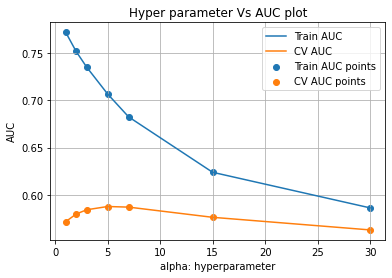

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.007339,4.692527e-04,0.004666,0.000471,1,{'alpha': 1},0.565879,0.581194,0.568273,0.571782,0.006727,6,0.773684,0.767121,0.773796,0.771534,0.003121
1,0.008669,2.358313e-03,0.006001,0.000816,2,{'alpha': 2},0.574613,0.588631,0.576341,0.579861,0.006241,4,0.753624,0.747262,0.752923,0.751270,0.002849
2,0.006004,4.052337e-07,0.004665,0.000471,3,{'alpha': 3},0.579717,0.592545,0.580786,0.584350,0.005811,3,0.737434,0.731158,0.735720,0.734771,0.002648
3,0.006004,2.081521e-06,0.005035,0.000059,5,{'alpha': 5},0.584479,0.594939,0.583959,0.587792,0.005058,1,0.709763,0.703312,0.706114,0.706396,0.002641
4,0.007341,1.251844e-03,0.004327,0.000466,7,{'alpha': 7},0.584990,0.593469,0.582987,0.587149,0.004543,2,0.686290,0.679293,0.681267,0.682283,0.002946


In [182]:
from sklearn.naive_bayes import MultinomialNB

clf_nb = MultinomialNB()
parameters = {'alpha':[1, 2, 3, 5, 7, 15,30]}
clf = GridSearchCV(clf_nb, parameters, cv=3, scoring='roc_auc',return_train_score=True)
clf.fit(X_tr, y_train)

summary=[]

results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_alpha'])

train_auc= results['mean_train_score']
train_auc_std= results['std_train_score']
cv_auc = results['mean_test_score'] 
cv_auc_std= results['std_test_score']
K =  results['param_alpha']

plt.plot(K, train_auc, label='Train AUC')

plt.plot(K, cv_auc, label='CV AUC')

plt.scatter(K, train_auc, label='Train AUC points')
plt.scatter(K, cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("Hyper parameter Vs AUC plot")
plt.grid()
plt.show()

results.head()

#### Testing the performance of the model on test data, plotting ROC Curves

In [183]:
clf.best_params_

{'alpha': 5}

In [184]:
best_alpha = 5

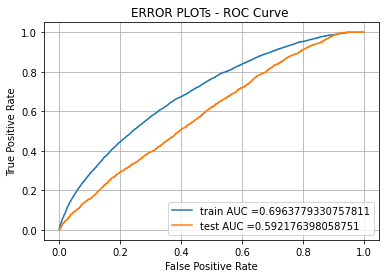

In [186]:
clf = MultinomialNB(alpha = best_alpha)
clf.fit(X_tr, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = batch_predict(clf, X_tr)    
y_test_pred = batch_predict(clf, X_cr)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_cv, y_test_pred)

summary.append(['Naive-Bayes',"alpha:"+str(best_alpha),np.round(auc(test_fpr, test_tpr),2)])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ERROR PLOTs - ROC Curve ")
plt.grid()
plt.show()

### 5.2.2 Gradient Boosted Decision trees

In [188]:
from xgboost import XGBClassifier


parameters = {
    'learning_rate' : [0.01, 0.1],
    #,'n_estimators' : [50,100,200],
    #'scale_pos_weight' : [1,3],
    #'max_depth' : [5,8,10],
    'colsample_bytree' : [0.2,0.3,0.4],
    #'gamma' : [0,1,2],
    #'subsample' : [0.8,0.9,1]
}

#Parameter to handle class imbalance for XGBoost Classifier
scale_pos_weight = Counter(y_train)[0]/Counter(y_train)[1]

xgb_model = XGBClassifier(scale_pos_weight=scale_pos_weight,n_estimators=1000)

#cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=1)

clf = GridSearchCV(xgb_model, parameters, cv=4, scoring='roc_auc',return_train_score=True)
clf.fit(X_tr, y_train,eval_metric="auc")

results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_learning_rate'])


train_auc= results['mean_train_score']
train_auc_std= results['std_train_score']
cv_auc = results['mean_test_score'] 
cv_auc_std= results['std_test_score']
#S_X =  results['param_n_estimators']
D_Y =  results['param_learning_rate']

results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_learning_rate,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
0,4.838597,0.133711,0.078009,0.007009,0.2,0.01,"{'colsample_bytree': 0.2, 'learning_rate': 0.01}",0.647207,0.666830,0.673722,0.669546,0.664326,0.010184,1,0.719783,0.714703,0.713507,0.714959,0.715738,0.002399
2,5.137167,0.091960,0.170278,0.157800,0.3,0.01,"{'colsample_bytree': 0.3, 'learning_rate': 0.01}",0.646986,0.666382,0.672801,0.668145,0.663579,0.009862,2,0.716103,0.711934,0.710642,0.712452,0.712783,0.002027
4,5.186923,0.080495,0.068009,0.006892,0.4,0.01,"{'colsample_bytree': 0.4, 'learning_rate': 0.01}",0.647432,0.664945,0.671115,0.667722,0.662803,0.009140,3,0.714037,0.709279,0.706072,0.710047,0.709859,0.002836
1,4.614792,0.068589,0.139778,0.006420,0.2,0.10,"{'colsample_bytree': 0.2, 'learning_rate': 0.1}",0.641479,0.657346,0.662965,0.657784,0.654893,0.008054,5,0.786593,0.781473,0.783380,0.783629,0.783769,0.001832
3,5.085645,0.100627,0.142281,0.009040,0.3,0.10,"{'colsample_bytree': 0.3, 'learning_rate': 0.1}",0.638390,0.657147,0.664705,0.656015,0.654064,0.009646,6,0.788610,0.781841,0.783058,0.785037,0.784637,0.002562


In [189]:
clf.best_params_

{'colsample_bytree': 0.2, 'learning_rate': 0.01}

In [ ]:
from mpl_toolkits import mplot3d
ax = plt.axes(projection='3d')

# Data for a three-dimensional line
ax.plot3D(S_X, D_Y, train_auc, 'red',label='Train')
ax.scatter3D(S_X, D_Y, train_auc,c= "red")
ax.plot3D(S_X, D_Y, cv_auc, 'blue',label='Cross Validation')
ax.scatter3D(S_X, D_Y, cv_auc,c= "blue")
plt.title('AUC Score')
plt.xlabel('n_estimators')
plt.ylabel('learning_rate')
plt.legend()

In [ ]:
learning_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
n_estimators = [50, 75, 100,200,500]

scores = clf.cv_results_['mean_train_score'].reshape(len(n_estimators),len(learning_rate))
plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot)
plt.xlabel('learning_rate')
plt.ylabel('n_estimators')
plt.colorbar()
plt.xticks(np.arange(len(learning_rate)), learning_rate)
plt.yticks(np.arange(len(n_estimators)), n_estimators)
plt.title('Grid Search Train AUC Score')
plt.show()

In [ ]:
learning_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
n_estimators = [50, 75, 100,200,500]

scores = clf.cv_results_['mean_test_score'].reshape(len(n_estimators),len(learning_rate))
plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot)
plt.xlabel('learning_rate')
plt.ylabel('n_estimators')
plt.colorbar()
plt.xticks(np.arange(len(learning_rate)), learning_rate)
plt.yticks(np.arange(len(n_estimators)), n_estimators)
plt.title('Grid Search Test AUC Score')
plt.show()

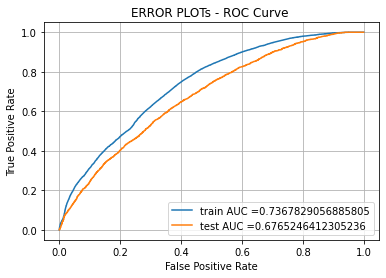

In [190]:
#here we are choosing the best_alpha based on forloop results
best_n_estimators = 1000
best_learning_rate = 0.01
best_scale_pos_weight =scale_pos_weight
best_colsample_bytree = 0.2
best_gamma = 3
best_max_depth= 8

# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc

scale_pos_weight = Counter(y_train)[0]/Counter(y_train)[1]

clf = XGBClassifier(n_estimators=best_n_estimators, learning_rate = best_learning_rate,scale_pos_weight=best_scale_pos_weight,
                   colsample_bytree=best_colsample_bytree,max_depth=best_max_depth,gamma = 1)
#clf = XGBClassifier(n_estimators=best_n_estimators, learning_rate = best_learning_rate,scale_pos_weight=best_scale_pos_weight)
clf.fit(X_tr, y_train,eval_metric="auc")
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = batch_predict(clf, X_tr)    
y_test_pred = batch_predict(clf, X_cr)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_cv, y_test_pred)

summary.append(['GBDT',"n_estimators:"+str(best_n_estimators)+" learning_rate: "+str(best_learning_rate),np.round(auc(test_fpr, test_tpr),2)])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ERROR PLOTs - ROC Curve ")
plt.grid()
plt.show()



In [191]:
y_test_pred = batch_predict(clf, X_te)
len(y_test_pred)

21805

In [192]:
policy_df_test = pd.read_csv('.data/test_YCcRUnU.csv')
  
ID = policy_df_test['ID']

pred = list(zip(ID, y_test_pred))  

final_df = pd.DataFrame(pred, columns = ['ID', 'Response'])  
final_df.to_csv('.predictions/rf_predictions.csv',index=False)  

### 5.2.3. Logistic Regression

In [193]:
from sklearn.linear_model import LogisticRegression

clf_lr = LogisticRegression()
parameters = {'C': np.logspace(-3, 3, 20)}
clf = GridSearchCV(clf_lr, parameters, cv=3, scoring='roc_auc',return_train_score=True)
clf.fit(X_tr, y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_C'])

train_auc= results['mean_train_score']
train_auc_std= results['std_train_score']
cv_auc = results['mean_test_score'] 
cv_auc_std= results['std_test_score']
S_X =  results['param_C']
#D_Y =  results['param_max_depth']

results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.055352,0.005438,0.003665,0.000470,0.001000,{'C': 0.001},0.598208,0.613658,0.610279,0.607381,0.006632,10,0.628149,0.614900,0.620208,0.621086,0.005444
1,0.067015,0.003560,0.003668,0.000472,0.002069,{'C': 0.00206913808111479},0.601706,0.620545,0.615649,0.612633,0.007981,8,0.633438,0.621420,0.626129,0.626996,0.004944
2,0.095019,0.002947,0.003337,0.000470,0.004281,{'C': 0.004281332398719396},0.604719,0.626282,0.620152,0.617051,0.009072,7,0.638928,0.627726,0.631907,0.632854,0.004622
3,0.140697,0.020855,0.003997,0.000003,0.008859,{'C': 0.008858667904100823},0.606543,0.629787,0.622455,0.619595,0.009703,5,0.644542,0.633596,0.637875,0.638671,0.004504
4,0.183379,0.014338,0.004335,0.000464,0.018330,{'C': 0.018329807108324356},0.607858,0.632356,0.623643,0.621286,0.010139,4,0.652185,0.641709,0.646152,0.646682,0.004293


In [195]:
print(clf.best_params_)

{'C': 0.07847599703514611}


In [196]:
best_c=0.0785

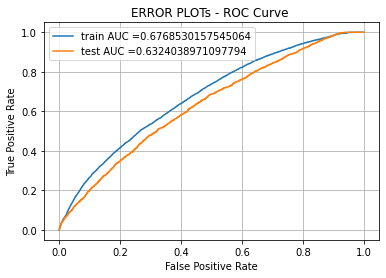

In [198]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc

clf = LogisticRegression(C=best_c)
clf.fit(X_tr, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = batch_predict(clf, X_tr)    
y_test_pred = batch_predict(clf, X_cr)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_cv, y_test_pred)

summary.append(['Logistic Regression',"Regularization C:"+str(best_c),np.round(auc(test_fpr, test_tpr),2)])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ERROR PLOTs - ROC Curve ")
plt.grid()
plt.show()

### 5.2.4 RandomForest

In [201]:
from sklearn.ensemble import RandomForestClassifier


clf_rf = RandomForestClassifier()
parameters = {'n_estimators':[10,50,100],
              'max_depth':[5,10,25,50],
              'max_features':[5,15,20,100]
             }
clf = GridSearchCV(clf_rf, parameters, cv=3, scoring='roc_auc',return_train_score=True)
clf.fit(X_tr, y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_n_estimators'])


train_auc= results['mean_train_score']
train_auc_std= results['std_train_score']
cv_auc = results['mean_test_score'] 
cv_auc_std= results['std_test_score']
S_X =  results['param_n_estimators']
#D_Y =  results['param_max_features']

results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.104016,0.002157,0.010673,0.000464,5,10,"{'max_depth': 5, 'n_estimators': 10}",0.544378,0.579563,0.549061,0.557667,0.015601,12,0.571003,0.583380,0.560102,0.571495,0.009510
3,0.188038,0.003552,0.011674,0.000475,10,10,"{'max_depth': 10, 'n_estimators': 10}",0.586321,0.574720,0.589073,0.583371,0.006220,11,0.620114,0.596784,0.613477,0.610125,0.009815
6,0.454109,0.006983,0.017336,0.001245,25,10,"{'max_depth': 25, 'n_estimators': 10}",0.609039,0.622194,0.617795,0.616342,0.005468,7,0.700202,0.683968,0.688076,0.690748,0.006892
9,0.918217,0.016304,0.024672,0.000943,50,10,"{'max_depth': 50, 'n_estimators': 10}",0.615100,0.631161,0.634726,0.626995,0.008537,5,0.800847,0.798796,0.799165,0.799603,0.000892
1,0.496807,0.016708,0.039682,0.002358,5,50,"{'max_depth': 5, 'n_estimators': 50}",0.593827,0.626715,0.602690,0.607744,0.013894,10,0.651418,0.645669,0.636772,0.644620,0.006025


In [202]:
print(clf.best_params_)

{'max_depth': 50, 'n_estimators': 100}


In [203]:
#here we are choosing the best_alpha based on forloop results
best_n_estimators=100
best_max_depth=80

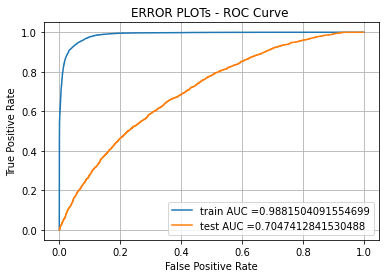

In [218]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier


clf = RandomForestClassifier(n_estimators=200,max_depth=100)
clf.fit(X_tr, y_train)

# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class

y_train_pred = batch_predict(clf, X_tr)    
y_test_pred = batch_predict(clf, X_cr)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_cv, y_test_pred)

summary.append(['Random Forest',"depth:"+str(best_max_depth)+"n_estimators: "+str(best_n_estimators),np.round(auc(test_fpr, test_tpr),2)])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ERROR PLOTs - ROC Curve ")
plt.grid()
plt.show()

## 5.3 Saving Prediction File

For the sake of the hackathon, the prediction file is created in the form of customer id and the probabilty that the customer is interested in the policy

In [ ]:
y_test_pred = batch_predict(clf, X_te)
len(y_test_pred)

In [220]:
policy_df_test = pd.read_csv('.data/test_YCcRUnU.csv')
  
ID = policy_df_test['ID']

pred = list(zip(ID, y_test_pred))  

final_df = pd.DataFrame(pred, columns = ['ID', 'Response'])  
final_df.to_csv('.predictions/rf_predictions.csv',index=False)  

## 6.Summary

In [210]:
from prettytable import PrettyTable

x = PrettyTable()
x.field_names = ["Model", "Hyper Parameter", "Accuracy"]

for i in range(4):
    x.add_row([summary[i][0],summary[i][1],summary[i][2]])
print(x)

+---------------------+---------------------------------------+----------+
|        Model        |            Hyper Parameter            | Accuracy |
+---------------------+---------------------------------------+----------+
|     Naive-Bayes     |                alpha:5                |   0.59   |
|         GBDT        | n_estimators:1000 learning_rate: 0.01 |   0.68   |
| Logistic Regression |        Regularization C:0.0785        |   0.63   |
|    Random Forest    |       depth:80n_estimators: 100       |   0.7    |
+---------------------+---------------------------------------+----------+


So from the above table, Random forest performed best on the pre-processed dataset and has given the best model performance